In [1]:
import sys
sys.path.append('/Users/joaoc/Documents/projects/SimulaCorona/.env/lib/python3.7/site-packages')

import pandas as pd
import numpy as np
import plotly.express as px
import yaml
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.dates as md
from tqdm import tqdm

from paths import *
from scripts import get_data, clean_data

%reload_ext autoreload
%autoreload 2

from datetime import datetime
date_time = datetime.today().strftime('%Y-%m-%d-%H-%M')

from scripts.io import to_gbq, read_gbq


pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

pd.options.display.max_colwidth = 100

def normalize_cols(df):
    return pd.Series(df).str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()

def create_region_id(city, state):
    """
    Join and clean city + state names to cross databases.
    """
    
    if city:
        city_state = city.upper() + ' ' + state
        return city_state
    
    return ''


In [2]:
def decide_scenario(c2, c3):
    
    if c2 < c3:
        return 'isolation'
    elif c2 >= c3:
        return 'lockdown'
    elif c2 == 0:
        return 'nothing'
    
def update_param(parameters, days, c2, c3):


    for v in config['scenarios'][decide_scenario(c2, c3)]['R0'].values():
        param['R0'] = v
        parameters.append(deepcopy(param))

In [3]:
def load_data():
    
#     df_cases_covid19br = get_data.city_cases_covid19br(config['get_data_paths']['cases_covid19br'])
    df_cases_brasilio = get_data.city_cases_brasilio(config['get_data_paths']['cases_brasilio'])

#     df_cases_covid19br = clean_data.treat_covid19br(config['raw_paths']['cases_covid19br'], config['treated_paths']['cases_covid19br'])
    df_cases_brasilio = clean_data.treat_brasilio(config['raw_paths']['cases_brasilio'], config['treated_paths']['cases_brasilio']) 

    df_sus = clean_data.treat_sus(config['raw_paths']['sus'], config['treated_paths']['sus'])

#     to_gbq(df_cases_brasilio, 'brasilio_cases', if_exists='replace')
#     to_gbq(df_sus, 'sus_capacity', if_exists='replace')

    df = pd.merge(df_cases_brasilio, df_sus, how='left', on='region_id')
    
    
    
    return df

In [4]:
def run_model_sequntial(df_city):
    
    final = pd.DataFrame()
    region_id = df_city['region_id'].iloc[0]
    for c2 in config['scenarios']['isolation']['dates']:
        for c3 in config['scenarios']['lockdown']['dates']:
            for bound in ['lower_bound', 'upper_bound']:

                model_params = {k: v[bound] 
                                for k, v in config['model_parameters']['seir'].items()}

                model_params.update(
                    {'days_from_t0': min(c2, c3),
                     'scenario': 'nothing',
                     'R0': config['scenarios']['nothing']['R0'][bound]
                    })

                exposed = (df_city['confirmed_inputed'].values[0] / 1.33 
                                * (1 + 1. / model_params['sick_days'])
                               ) / model_params['sigma']
                current_state = {
                    'population': df_city['populacao'].values[0],
                    'exposed': exposed,
                    'current_infected': df_city['confirmed_inputed'].values[0],
                    'suceptible': df_city['populacao'].values[0] \
                                  - df_city['confirmed_inputed'].values[0] \
                                  - exposed,
                    'recovered': 0
                }

                res = seir.entrypoint(current_state, 
                                     model_params)

                model_params.update(
                    {'days_from_t0': max(c2, c3) - min(c2, c3),
                     'scenario': decide_scenario(c2, c3),
                     'R0': config['scenarios'][decide_scenario(c2, c3)]['R0'][bound]
                    })

                current_state['suceptible'] = res['S'].iloc[-1]
                current_state['exposed'] = res['E'].iloc[-1]
                current_state['current_infected'] = res['I'].iloc[-1]
                current_state['recovered'] = res['R'].iloc[-1]

                res = pd.concat([res, seir.entrypoint(current_state, 
                                                 model_params)[1:]])

                model_params.update(
                        {'days_from_t0': config['estimation_days'] - max(c2, c3),
                         'scenario': decide_scenario(c3, c2),
                         'R0': config['scenarios'][decide_scenario(c3, c2)]['R0'][bound]
                        })

                current_state['suceptible'] = res['S'].iloc[-1]
                current_state['exposed'] = res['E'].iloc[-1]
                current_state['current_infected'] = res['I'].iloc[-1]
                current_state['recovered'] = res['R'].iloc[-1]


                res = pd.concat([res, seir.entrypoint(current_state, 
                                                 model_params)[1:]])


                res = res.reset_index(drop=True).reset_index().drop('days', 1).rename(columns={'index': 'days'})
                res['isolation_t'] = c2
                res['lockdown_t'] = c3
                res['bound'] = bound
                res['region_id'] = region_id
                
                final = pd.concat([final, res])
            
    final = final.pivot_table(index=['region_id', 'isolation_t', 'lockdown_t', 'days'], 
                      columns='bound', 
                      values=['I1', 'I2', 'I3', 'S', 'I', 'R', 'E'])

    final.columns = ['_'.join(col).strip() for col in final.columns.values]
    final = final.reset_index()
    final = final.merge(df[['region_id', 'quantidade_leitos', 'ventiladores_existentes',
                            'city_name', 'state', 'sus_region_name']], on='region_id')
    
#     to_gbq(final, 'model_evolution', if_exists='append',
# #       progress_bar=False
#       )
    
#     final.to_csv(TREAT_PATH / 'cities' / (region_id + '.csv'), index=False)
#     return(final)
#     final.to_csv('vale_test.csv', index=False)

    return(final)

In [5]:
def pivot_to(_df, key):
    a = _df.pivot_table(index='variation_perc', columns='resource', values=key, dropna=False)
    return a.rename(columns={c: key + '_' + c for c in a.columns})



def get_limits(_df):
    
    d = []
    for arg in config['resources']:
        for variation_perc in arg['variation_perc']:
            for bound in ['lower', 'upper']:
                
                var = variation_perc / 100
                n_resource = int(_df[arg['resource']].iloc[0] * var)
                
                day = _df[n_resource < _df[f'{arg["infected"]}_{bound}_bound']].head(1)

                if len(day):
                    dday = day['days'].values[0]
                else:
                    dday = np.nan
                    
                res = {}    
                res['resource'] = f'{arg["resource"]}_{bound}'
                res['dday'] =  dday
                res['variation_perc'] = variation_perc
                res['number'] = n_resource
                
                d.append(res)
    d = pd.DataFrame(d)
    return pd.concat([pivot_to(d, 'dday'), pivot_to(d, 'number')], 1)

In [6]:
from models import seir

In [7]:
config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)


# Get Values

In [41]:
# maps = gpd.read_file('../data/raw/sp_municipios.json')

In [42]:
# dd = read_gbq('select * from `robusta-lab.simula_corona.cities_cases`')
# dd['region_id'] = dd.apply(lambda row: create_region_id(row['state'], row['city_name']), axis=1)
# dd['region_id'] = normalize_cols(dd['region_id'])

In [43]:
# mask = maps['nome_mesorregiao']=='Vale do Paraíba Paulista'
# vale = maps[mask][['nome_municip_ibge']]

# vale =  vale.rename(columns={'nome_municip_ibge':'city'})
# vale['state'] = 'SP'
# # Create id for join
# vale['region_id'] = vale.apply(lambda row: create_region_id(row['state'], row['city']), axis=1)
# vale['region_id'] = normalize_cols(vale['region_id'])
# vale = vale.drop(['city','state'],1)

# vf = pd.merge(vale, dd, how='left', on=['region_id'])
# vf = vf[vf['state'].notnull()]

In [44]:
# region_ids = ['SP TAUBATE']
# mask = vf['region_id'].isin(region_ids)
# df = vf[mask]

In [45]:
# vf.to_csv('vale_cases.csv', index=False)

## Run Model

In [10]:
df = pd.read_csv('vale_cases.csv')

In [36]:
from multiprocessing.pool import Pool
from functools import partial
import time
from scripts import vis
config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)

region_ids = ['SP TAUBATE']

final = pd.DataFrame()
for region_id in region_ids:
    print(region_id)
    final = pd.concat([final, run_model_sequntial(df.query(f"region_id == '{region_id}'"))],0)

SP TAUBATE


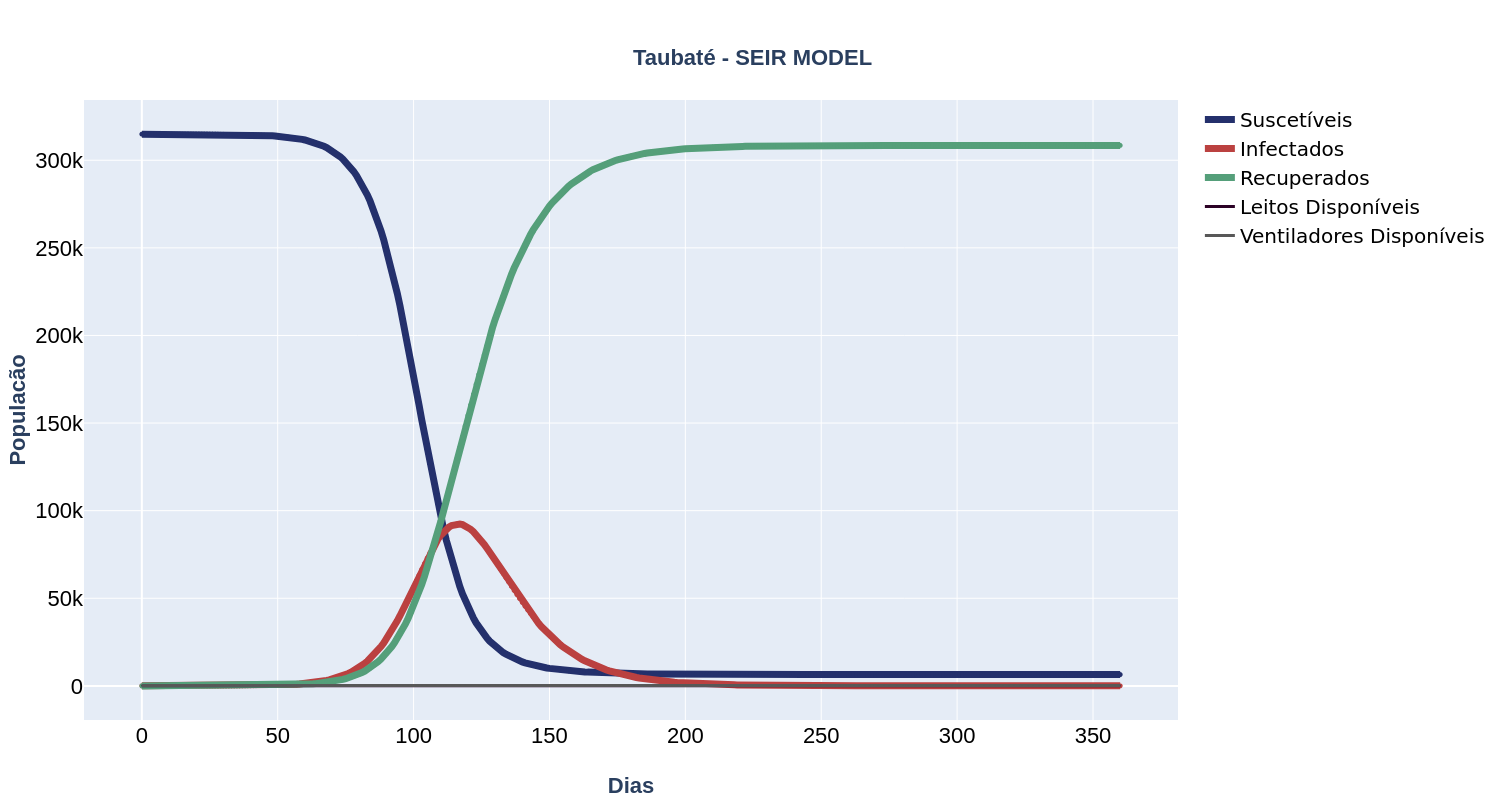

In [37]:
columns = {
    'S_upper_bound':"Suscetíveis",
#     'E_upper_bound':'Expostos',
    'I_upper_bound':'Infectados',
    'R_upper_bound':'Recuperados',
    'quantidade_leitos':'Leitos Disponíveis',
    'ventiladores_existentes':'Ventiladores Disponíveis'
}
# colors =  ['#24306C',"#EDA922","#BB4140",'#559F7A','#2C0226' ,'#585858']
colors =  ['#24306C',"#BB4140",'#559F7A','#2C0226' ,'#585858']
# colors =  ["#BB4140",'#2C0226' ,'#585858']

# vis.show_colors(colors)

vis.plot_simulation(final,columns,colors ,perc_leitos=0.2)

In [174]:
dday = final.groupby(['region_id', 'isolation_t', 'lockdown_t'])\
        .apply(get_limits).reset_index()

In [175]:
dday = dday.merge(df[['region_id', 'city_name', 'state', 'sus_region_name']], 
                  on='region_id')

In [176]:
best_case = dday.query('lockdown_t == 1')\
            .query('isolation_t == 60')\
            .query('variation_perc == 20')\
            .drop(['lockdown_t', 'isolation_t'], 1)
worst_case = dday.query('lockdown_t == 60')\
            .query('isolation_t == 60')\
            .query('variation_perc == 20').drop(['lockdown_t', 'isolation_t'], 1)

In [177]:
dday

,region_id,isolation_t,lockdown_t,variation_perc,dday_quantidade_leitos_lower,dday_quantidade_leitos_upper,dday_ventiladores_existentes_lower,dday_ventiladores_existentes_upper,number_quantidade_leitos_lower,number_quantidade_leitos_upper,number_ventiladores_existentes_lower,number_ventiladores_existentes_upper,city_name,state,sus_region_name
0,SP TAUBATE,1,1,10,NaN,NaN,NaN,NaN,50,50,14,14,Taubaté,SP,Taubaté
1,SP TAUBATE,1,1,20,NaN,NaN,NaN,NaN,101,101,29,29,Taubaté,SP,Taubaté
2,SP TAUBATE,1,1,50,NaN,NaN,NaN,NaN,254,254,74,74,Taubaté,SP,Taubaté
3,SP TAUBATE,1,1,75,NaN,NaN,NaN,NaN,381,381,111,111,Taubaté,SP,Taubaté
4,SP TAUBATE,1,1,100,NaN,NaN,NaN,NaN,509,509,148,148,Taubaté,SP,Taubaté
5,SP TAUBATE,1,1,125,NaN,NaN,NaN,NaN,636,636,185,185,Taubaté,SP,Taubaté
6,SP TAUBATE,1,1,150,NaN,NaN,NaN,NaN,763,763,222,222,Taubaté,SP,Taubaté
7,SP TAUBATE,1,1,200,NaN,NaN,NaN,NaN,1018,1018,296,296,Taubaté,SP,Taubaté
8,SP TAUBATE,1,2,10,NaN,NaN,NaN,NaN,50,50,14,14,Taubaté,SP,Taubaté
9,SP TAUBATE,1,2,20,NaN,NaN,NaN,NaN,101,101,29,29,Taubaté,SP,Taubaté


In [60]:
to_gbq(best_case, 'best_case', if_exists='append')
to_gbq(worst_case, 'worst_case', if_exists='append')


1it [00:03,  3.33s/it]

1it [00:03,  3.85s/it]


In [ ]:
keep = ['region_id', 'isolation_t', 'lockdown_t', 'variation_perc',  'city_name', 'state', 'sus_region_name']
for r in config['resources']:
    temp = dday[keep + [c for c in dday.columns if r['resource'] in c]]
    temp = temp.rename(columns={'variation_perc': f'variation_perc_{r["resource"]}'})
    to_gbq(temp,
           f'dday_{r["resource"]}_filter', if_exists='append')


In [121]:
final.columns

Index(['region_id', 'isolation_t', 'lockdown_t', 'days', 'E_lower_bound',
       'E_upper_bound', 'I_lower_bound', 'I_upper_bound', 'I1_lower_bound',
       'I1_upper_bound', 'I2_lower_bound', 'I2_upper_bound', 'I3_lower_bound',
       'I3_upper_bound', 'R_lower_bound', 'R_upper_bound', 'S_lower_bound',
       'S_upper_bound', 'quantidade_leitos', 'ventiladores_existentes',
       'city_name', 'state', 'sus_region_name'],
      dtype='object')

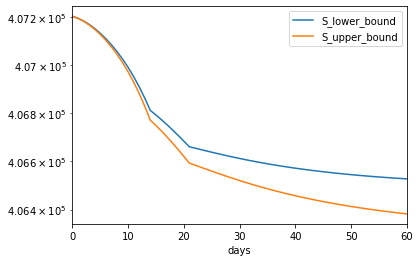

In [158]:
final.query('region_id == "AC RIO BRANCO"')\
.query('isolation_t == 14').query('lockdown_t == 21').set_index('days')\
[['S_lower_bound', 'S_upper_bound']].plot(logy=True)

In [84]:
(15 - 10 + 1. / 15 * 10) / 0.2 

28.333333333333332

In [83]:
(15 - 10 * (1 + 1./15)) / 0.2

21.666666666666668

In [ ]:
(I1 - I0 + gamma * I0) / sigma

In [99]:
I1 = 13
I0 = 10
gamma = 1./15
sigma = 0.2

In [100]:
(I1 - I0 * (1 + gamma)) / sigma

11.66666666666667

In [103]:
(I1 - gamma) * I0 / sigma 

646.6666666666666

In [ ]:
I1 - I0 = sigma * E0 - gamma * I0

In [ ]:
( I1 - I0 + I0 * gamma) / sigma
( I1 - I0 (1  + gamma) ) / sigma

In [ ]:
(I1 - I0 (1 + gamma)) / sigma

In [ ]:
E0 = (I0 / sigma) * (I1 + gamma) 

In [ ]:
I1 / I0 ~ 1.33

In [ ]:
I1 / 1.33 = I0 

In [95]:
I0 = I1 / 1.33

In [96]:
I0

11.278195488721805

In [101]:
(I1 - I0 * (1 + gamma)) / sigma

11.66666666666667